In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 2

In [26]:
%reload_ext autoreload

In [27]:
# from ..src.event_processing import leer_excel
# ImportError: attempted relative import with no known parent package

# This notebook is in /SampleData
# The src folder is in the parent directory
# We need to add the parent directory to the path
import sys

sys.path.append("../")

from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

In [2]:
import numpy as np
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_jugadores

In [3]:
partidos = separar_partidos(epl)
sample_partido = partidos[np.random.randint(len(partidos))]


In [4]:
data = sample_partido
data.loc[:, "prev_team"] = data["team_id"].shift(1)
data.loc[:, "is_gain"] = data["team_id"] != data["prev_team"]

data.loc[:, "next_team"] = data["team_id"].shift(-1)
data.loc[:, "is_loss"] = data["team_id"] != data["next_team"]

data.loc[:, "is_gain"] = data["is_gain"].fillna(False)
data.loc[:, "is_loss"] = data["is_loss"].fillna(False)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/2405552128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "prev_team"] = data["team_id"].shift(1)
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/2405552128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "is_gain"] = data["team_id"] != data["prev_team"]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/2405552128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a co

In [5]:
equipos = separar_partido_en_equipo_pov(sample_partido)
sample_equipo = equipos[np.random.randint(2)]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
sample_lineup = lineups[np.random.randint(2)]
jugadores = get_jugadores(sample_lineup)
jugador = jugadores[np.random.randint(len(jugadores))]

In [6]:
sample_lineup.groupby("player_id")[["is_gain", "is_loss"]].sum()

,is_gain,is_loss
player_id,,
6240.0,1,1
7933.0,0,1
17974.0,2,4
20480.0,1,1
21060.0,2,2
27341.0,1,0
42727.0,1,0
42758.0,1,2
55604.0,7,5


In [7]:
jugador

42758.0

In [8]:
# set player_id as index
sample_lineup.groupby("player_id")[["is_gain"]].sum().loc[jugador].values[0]

np.int64(1)

In [9]:
from src.futbol_types import TransitionMatrix
from src.utils_CTMC import build_R, build_Q


R = build_R(sample_lineup)
print(type(R))

<class 'numpy.ndarray'>


In [10]:
del build_Q

In [11]:
Q: TransitionMatrix = np.array(R.copy())

for i in range(14):
    if np.sum(Q[i, :]) != 0:
        Q[i, :] = Q[i, :] / np.sum(Q[i, :])

Q.shape

(14, 14)

In [12]:
# Define the following block decomposition of Q_g(A)

#           |  T_{12x12}   R_{12x2}  |
# Q_g(A) =  |
#           |  0_{2x12}    I_{2x2}   |

# where T contains the transition probabilities between transient states,
# R contains the transition probabilities from transient to absorbing states,
# 0 is a block of all zeros and I is an identity block.
#
# Leveraging this decomposition, the probability of shot before loss p_g(A) can be estimated from Qq(A) as we state in the following definition.

# psl = p^_g(A) = [1, 0_{1×11}](I_{12x12} - T)^{-1} R[0, 1]^T

# [1, 0_{1×11}] is a row vector of length 12 with a 1 in the first position and zeros elsewhere.
# [0, 1]^T is a column vector of length 2 with a 1 in the second position and zeros elsewhere.

# The matrix (I_{12x12} - T)^{-1} is the inverse of the matrix I_{12x12} - T.
# The inverse of a matrix is a matrix that when multiplied by the original matrix gives an identity matrix.

T: np.ndarray = Q[:12, :12]
R: np.ndarray = Q[:12, 12:]
I: np.ndarray = np.eye(2)
Z: np.ndarray = np.zeros((2, 12))

M = (np.eye(12) - T)

M_inv = np.linalg.inv(M)

psl = np.dot(np.dot(np.array([1] + [0] * 11), M_inv), R).dot(np.array([0, 1]).T)
psl

np.float64(0.0)

In [13]:
def psl_estimator_(Q: TransitionMatrix) -> float:
    T: np.ndarray = Q[:12, :12]
    R: np.ndarray = Q[:12, 12:]
    I: np.ndarray = np.eye(2)
    Z: np.ndarray = np.zeros((2, 12))

    M = (np.eye(12) - T)

    M_inv = np.linalg.inv(M)

    psl = np.dot(np.dot(np.array([1] + [0] * 11), M_inv), R).dot(np.array([0, 1]).T)
    return psl

In [14]:
from src.match_data_extraction import get_lineup_duration
from src.utils_CTMC import psl_estimator, build_Q, build_R

lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
psls = np.array([psl_estimator(build_Q(build_R(lineup))) for lineup in lineups])
lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

np.average(psls, weights=lineup_durations)

np.float64(0.009273733780925022)

In [15]:
from src.utils_CTMC import team_psl

team_psl(sample_equipo)

np.float64(0.009273733780925022)

In [16]:
sample_equipo[sample_equipo["type"] == 16]

,season_id,match_id,home_team_id,home_team_name,away_team_id,away_team_name,id,event_id,date,time,...,playerPosition,x,y,type,description,outcome,prev_team,is_gain,next_team,is_loss
395572,2012,442230,7,Aston Villa,4,Newcastle United,1640282175,212,29Jan2013,20:03:12,...,Striker,86.9,39.1,16,Goal,1,4.0,False,7.0,True
395778,2012,442230,7,Aston Villa,4,Newcastle United,2117694788,303,29Jan2013,20:15:31,...,Midfielder,78.3,66.8,16,Goal,1,7.0,True,7.0,True


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix


<Axes: >

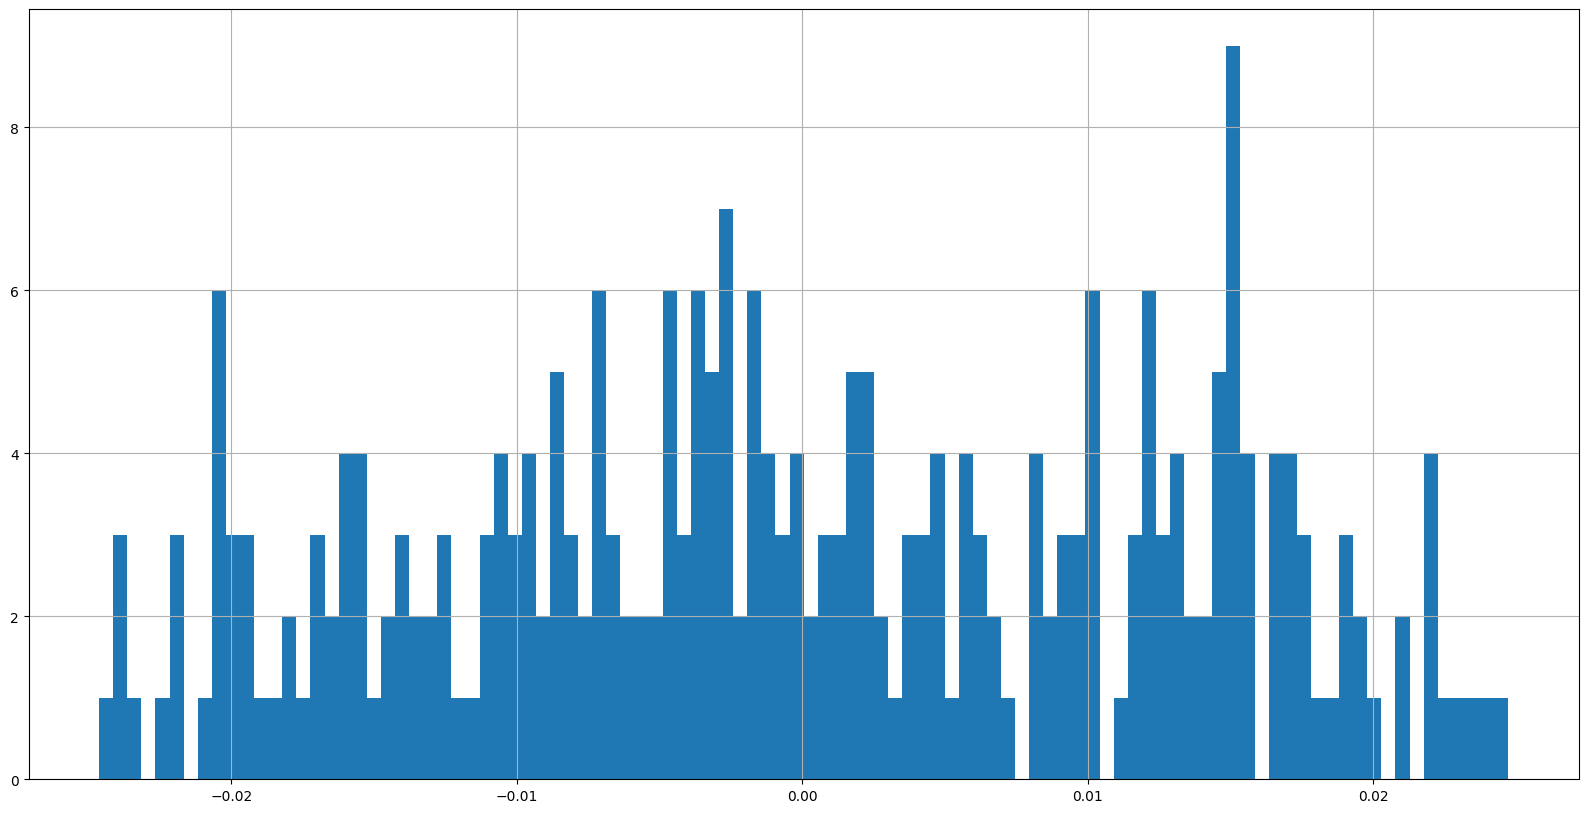

In [18]:
delta_psls = []
results = []
missed = []

def add_gains_loss_col(partido):
    df = partido.copy()
    df.loc[:, "prev_team"] = df["team_id"].shift(1)
    df.loc[:, "is_gain"] = df["team_id"] != df["prev_team"]

    df.loc[:, "next_team"] = df["team_id"].shift(-1)
    df.loc[:, "is_loss"] = df["team_id"] != df["next_team"]

    df.loc[:, "is_gain"] = df["is_gain"].fillna(False)
    df.loc[:, "is_loss"] = df["is_loss"].fillna(False)
    return df

for partido in partidos:
    equipos = separar_partido_en_equipo_pov(add_gains_loss_col(partido))

    psl_0 = team_psl(equipos[0])
    psl_1 = team_psl(equipos[1])

    delta_psl = psl_0 - psl_1

    if np.isnan(delta_psl):
        missed.append(partido)
    else:
        goals_0 = equipos[0][equipos[0]["type"] == 16].shape[0]
        goals_1 = equipos[1][equipos[1]["type"] == 16].shape[0]

        r = 1
        if goals_0 > goals_1:
            r = 2
        elif goals_0 < goals_1:
            r = 0

        delta_psls.append(delta_psl)
        results.append(r)

data = pd.DataFrame({"Delta PSL": delta_psls, "Result": results})
data = data[data["Delta PSL"].abs() < 0.025]

fig, ax = plt.subplots(figsize=(20, 10))
data["Delta PSL"].hist(bins=100, ax=ax)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/3346853269.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = data.groupby(bins)["Result"].sum().reset_index()
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/3346853269.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total["Total"] = data.groupby(bins)["Result"].count().values
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_30588/3346853269.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

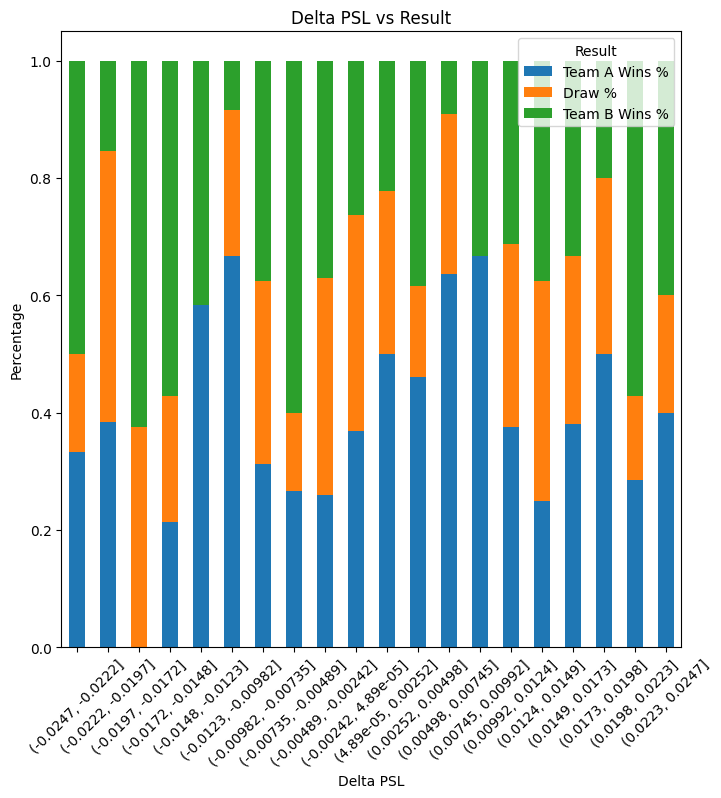

In [21]:
# Crear los bins
bin_count = 20
bins = pd.cut(data["Delta PSL"], bins=bin_count)

# Calcular los porcentajes
total = data.groupby(bins)["Result"].sum().reset_index()
total["Total"] = data.groupby(bins)["Result"].count().values

counts = data.groupby(bins)["Result"].value_counts()
counts = counts.unstack().reset_index()
counts["Total"] = total["Total"]

counts["Team A Wins %"] = counts[2] / counts["Total"]
counts["Draw %"] = counts[1] / counts["Total"]
counts["Team B Wins %"] = counts[0] / counts["Total"]

# stacked bar plot

fig, ax = plt.subplots(figsize=(8, 8))
counts[["Team A Wins %", "Draw %", "Team B Wins %"]].plot(
    kind="bar", stacked=True, ax=ax
)

ax.set_xticks(range(bin_count), counts["Delta PSL"].values, rotation=45)
# plt.xticks([], [])

# X lim in between -0.02 and 0.02

ax.set_xlabel("Delta PSL")

ax.set_ylabel("Percentage")
plt.title("Delta PSL vs Result")

plt.show()

In [23]:
from src.CTMC_Dataset import Dataset

ds = Dataset("../SampleData/epl.xlsx")

In [38]:
ds.features.reshape((ds.features.shape[0], -1))

array([], shape=(275126, 0), dtype=float64)

In [39]:
ds.target

array([[0.08062349],
       [0.0161247 ],
       [0.0161247 ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [24]:
ds_df = pd.DataFrame(
    np.concatenate([ds.features, ds.target], axis=1),
    columns=ds.columns + ["target"],
)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [4]:
import numpy as np

In [8]:
import pandas as pd

In [10]:
epl.columns

Index(['season_id', 'match_id', 'home_team_id', 'home_team_name',
       'away_team_id', 'away_team_name', 'id', 'event_id', 'date', 'time',
       'period_id', 'min', 'sec', 'team_id', 'player_id', 'playerName',
       'playerPosition', 'x', 'y', 'type', 'description', 'outcome'],
      dtype='object')

In [58]:
from src.utils_CTMC import (
    get_ratio_gains,
    get_ratio_loss,
    get_ratio_shots,
    get_ratio_passes,
)
from src.match_data_extraction import get_lineup_duration


def get_features(player_1, partido):
    # For a given player, get aggregated features for all matches played before partido
    # home_team_id if player_1 is in home team, away_team_id if player_1 is in away team
    team_id = partido[partido["player_id"] == player_1]["team_id"].values[0]

    player_data = {
        "pases/90" : 0,
        "shots/90" : 0,
        "losses/90" : 0,
        "gains/90" : 0,
        "minutes" : 0
    }

    # Get all matches played
    date = partido["date"].values[0]
    prev_matches = epl[epl["date"] < date]
    for partido in separar_partidos(prev_matches):
        for equipo in separar_partido_en_equipo_pov(partido):
            if equipo["team_id"].values[0] == team_id:
                if player_1 in get_jugadores(equipo):
                    for lineup in separar_partido_del_equipo_en_lineups(equipo):
                        players = get_jugadores(lineup)
                        if player_1 in players:
                            minutes = get_lineup_duration(lineup)
                            if minutes == 0:
                                continue

                            player_data["shots/90"] += get_ratio_shots(lineup, player_1)
                            player_data["losses/90"] += get_ratio_loss(lineup, player_1)
                            player_data["gains/90"] += get_ratio_gains(lineup, player_1)

                            player_data["minutes"] += minutes

                            passes = lineup[
                                (lineup["player_id"] == player_1)
                                & (lineup["type"] == 1)
                                & (lineup["outcome"] == 1)
                            ]
                            
                            player_data["pases/90"] += passes.shape[0] / minutes

    return player_data

In [31]:
partidos = separar_partidos(epl)
sample_partido = partidos[np.random.randint(len(partidos))]

sample_player = get_jugadores(sample_partido)[np.random.randint(11)]
sample_player

20467.0

In [59]:
get_features(sample_player, sample_partido)

{'pases/90': 14.891504768534878,
 'shots/90': 2.958271969613543,
 'losses/90': np.float64(23.547398788803),
 'gains/90': np.float64(16.100066791621366),
 'minutes': 3395.733333333333}

In [32]:
sample_partido["date"].values[0]  # '23Sep2012'

np.datetime64('2013-05-04T00:00:00.000000000')

In [67]:
epl.columns

Index(['season_id', 'match_id', 'home_team_id', 'home_team_name',
       'away_team_id', 'away_team_name', 'id', 'event_id', 'date', 'time',
       'period_id', 'min', 'sec', 'team_id', 'player_id', 'playerName',
       'playerPosition', 'x', 'y', 'type', 'description', 'outcome'],
      dtype='object')

In [69]:
from tqdm import tqdm

In [89]:
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_jugadores
from src.utils_CTMC import get_ratio_passes

features = []
target = []

cache = {}

# if partido id in cache, get data from cache
iterator = tqdm(separar_partidos(epl))
for partido in iterator:
    partido_id = partido["match_id"].values[0]
    for equipo in separar_partido_en_equipo_pov(partido):
        team_id = equipo['team_id'].values[0]
        for lineup in separar_partido_del_equipo_en_lineups(equipo):
            players = get_jugadores(lineup)

            for player_1 in players:
                player_1_key = (partido_id, player_1)
                if player_1_key not in cache:
                    player_1_vec = get_features(player_1, partido)
                    cache[player_1_key] = player_1_vec
                else:
                    player_1_vec = cache[player_1_key]

                for player_2 in players:

                    iterator.set_description(f"Match ID: {partido_id} Team ID: {team_id} Player 1: {player_1} Player 2: {player_2}")

                    if player_1 != player_2:
                        player_2_key = (partido_id, player_2)
                        if player_2_key not in cache:
                            player_2_vec = get_features(player_2, partido)
                            cache[player_2_key] = player_2_vec
                        else:
                            player_2_vec = cache[player_2_key]

                        features.append(
                            [
                                player_1,
                                player_1_vec["pases/90"],
                                player_1_vec["shots/90"],
                                player_1_vec["losses/90"],
                                player_1_vec["gains/90"],
                                player_1_vec["minutes"],
                                player_2,
                                player_2_vec["pases/90"],
                                player_2_vec["shots/90"],
                                player_2_vec["losses/90"],
                                player_2_vec["gains/90"],
                                player_2_vec["minutes"],
                                partido_id,
                            ]
                        )
                        target.append(
                            [
                                get_ratio_passes(lineup, player_1, player_2),
                            ]
                        )

columns = [
    "player_1",
    "pases/90_1",
    "shots/90_1",
    "losses/90_1",
    "gains/90_1",
    "minutes_1",
    "player_2",
    "pases/90_2",
    "shots/90_2",
    "losses/90_2",
    "gains/90_2",
    "minutes_2",
    "partido_id",
]
features = np.array(features)
target = np.array(target)

Match ID: 442378 Team ID: 111 Player 1: 125510.0 Player 2: 125510.0: 100%|██████████| 380/380 [1:53:22<00:00, 17.90s/it]


In [90]:
ds = pd.DataFrame(
    np.concatenate([features, target], axis=1), columns=columns + ["target"]
)

# save as csv
ds.to_csv("dataset.csv", index=False)

In [95]:
def get_match_data(match_id):
    match_events = epl[epl["match_id"] == match_id]
    date = match_events["date"].values[0]
    # home_team = epl[epl["match_id"] == match_id]["home_team_id"].values[0]
    # away_team = epl[epl["match_id"] == match_id]["away_team_id"].values[0]
    # home_team_id = epl[epl["match_id"] == match_id]["home_team_id"].values[0]
    # away_team_id = epl[epl["match_id"] == match_id]["away_team_id"].values[0]

    # passes = match_events[(match_events["type"] == 1) & (match_events["outcome"] == 1)]
    # shots = match_events[(match_events["type"].isin([15, 16])) & (match_events["outcome"] == 1)]

    return date

ds["date"] = ds["partido_id"].apply(get_match_data)

In [96]:
ds

,player_1,pases/90_1,shots/90_1,losses/90_1,gains/90_1,minutes_1,player_2,pases/90_2,shots/90_2,losses/90_2,gains/90_2,minutes_2,partido_id,target,date
0,17733.0,0.000000,0.000000,0.000000,0.000000,0.000000,19524.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.080623,2012-08-18
1,17733.0,0.000000,0.000000,0.000000,0.000000,0.000000,15943.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
2,17733.0,0.000000,0.000000,0.000000,0.000000,0.000000,20467.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
3,17733.0,0.000000,0.000000,0.000000,0.000000,0.000000,80254.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
4,17733.0,0.000000,0.000000,0.000000,0.000000,0.000000,8758.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.032249,2012-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275121,125510.0,0.096057,0.217421,0.301946,0.302615,284.033333,28491.0,13.305668,0.040368,9.434056,13.054697,4749.983333,442378.0,0.000000,2013-05-19
275122,125510.0,0.096057,0.217421,0.301946,0.302615,284.033333,74235.0,1.175434,0.000000,1.290463,1.417895,290.300000,442378.0,0.000000,2013-05-19
275123,125510.0,0.096057,0.217421,0.301946,0.302615,284.033333,106458.0,0.000000,0.000000,0.000000,0.000000,0.000000,442378.0,0.000000,2013-05-19
275124,125510.0,0.096057,0.217421,0.301946,0.302615,284.033333,76227.0,0.000000,0.000000,0.000000,0.000000,0.000000,442378.0,0.000000,2013-05-19


In [97]:
ds.to_csv("dataset.csv", index=False)

In [1]:
ds = pd.read_csv("dataset.csv")

NameError: name 'pd' is not defined

In [98]:
ds = ds[ds["target"] != 0]
ds

,player_1,pases/90_1,shots/90_1,losses/90_1,gains/90_1,minutes_1,player_2,pases/90_2,shots/90_2,losses/90_2,gains/90_2,minutes_2,partido_id,target,date
0,17733.0,0.000000,0.000000,0.00000,0.000000,0.000000,19524.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.080623,2012-08-18
1,17733.0,0.000000,0.000000,0.00000,0.000000,0.000000,15943.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
2,17733.0,0.000000,0.000000,0.00000,0.000000,0.000000,20467.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
3,17733.0,0.000000,0.000000,0.00000,0.000000,0.000000,80254.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.016125,2012-08-18
4,17733.0,0.000000,0.000000,0.00000,0.000000,0.000000,8758.0,0.000000,0.000000,0.000000,0.000000,0.000000,441999.0,0.032249,2012-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275088,106458.0,0.000000,0.000000,0.00000,0.000000,0.000000,16210.0,11.730740,0.125619,9.055907,11.925083,2265.200000,442378.0,0.010751,2013-05-19
275092,106458.0,0.000000,0.000000,0.00000,0.000000,0.000000,74235.0,1.175434,0.000000,1.290463,1.417895,290.300000,442378.0,0.010751,2013-05-19
275100,76227.0,0.000000,0.000000,0.00000,0.000000,0.000000,50105.0,6.379166,0.015839,5.568527,4.993918,1268.283333,442378.0,0.010751,2013-05-19
275103,76227.0,0.000000,0.000000,0.00000,0.000000,0.000000,106458.0,0.000000,0.000000,0.000000,0.000000,0.000000,442378.0,0.010751,2013-05-19


In [81]:
import xgboost as xgb

In [113]:
dates = ds["date"]
date_2_3 = dates.mean() + 2/3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

(82550, 33448, 0.7116502008655322, 0.28834979913446784)

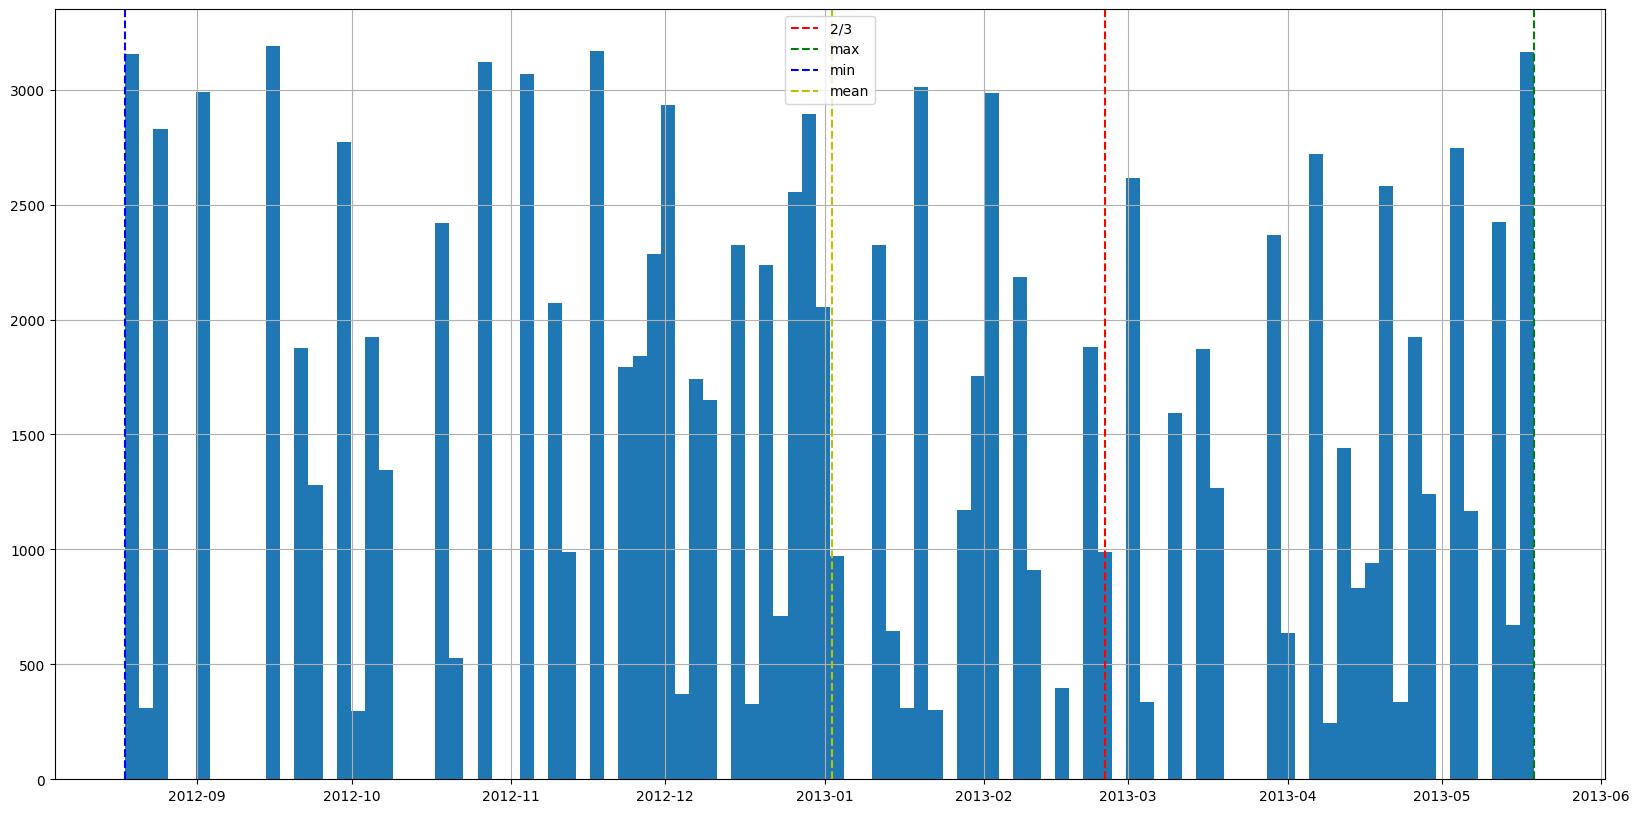

In [116]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

In [117]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[ds["player_1"].isin(sample_pairs["player_1"]) & ds["player_2"].isin(sample_pairs["player_2"])]
train = ds[~ds["player_1"].isin(sample_pairs["player_1"]) | ~ds["player_2"].isin(sample_pairs["player_2"]) | ~ds["player_1"].isin(sample_pairs["player_2"]) | ~ds["player_2"].isin(sample_pairs["player_1"])]

train_left = train[train["date"] < date_2_3]
test_right = test[test["date"] >= date_2_3]

In [118]:
xgb_model = xgb.XGBRegressor()

X_train = train_left.drop(columns=["player_1", "player_2", "target", "date", "partido_id"])
y_train = train_left["target"]

X_test = test_right.drop(columns=["player_1", "player_2", "target", "date", "partido_id"])
y_test = test_right["target"]

xgb_model.fit(X_train, y_train)

sc = xgb_model.score(X_test, y_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, xgb_model.predict(X_test))

sc, mse

(-0.07232076012826782, np.float64(0.007969793757078769))

<Axes: >

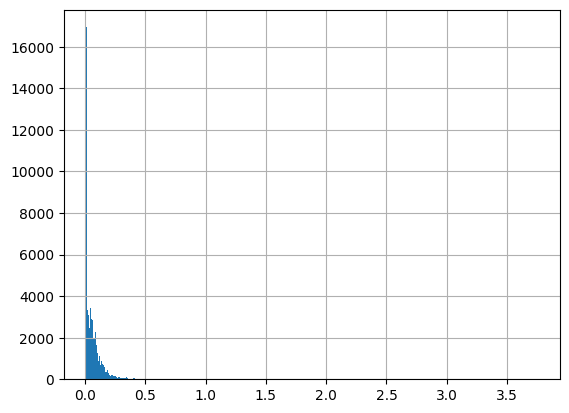

In [119]:
ds["target"].hist(bins=1000)

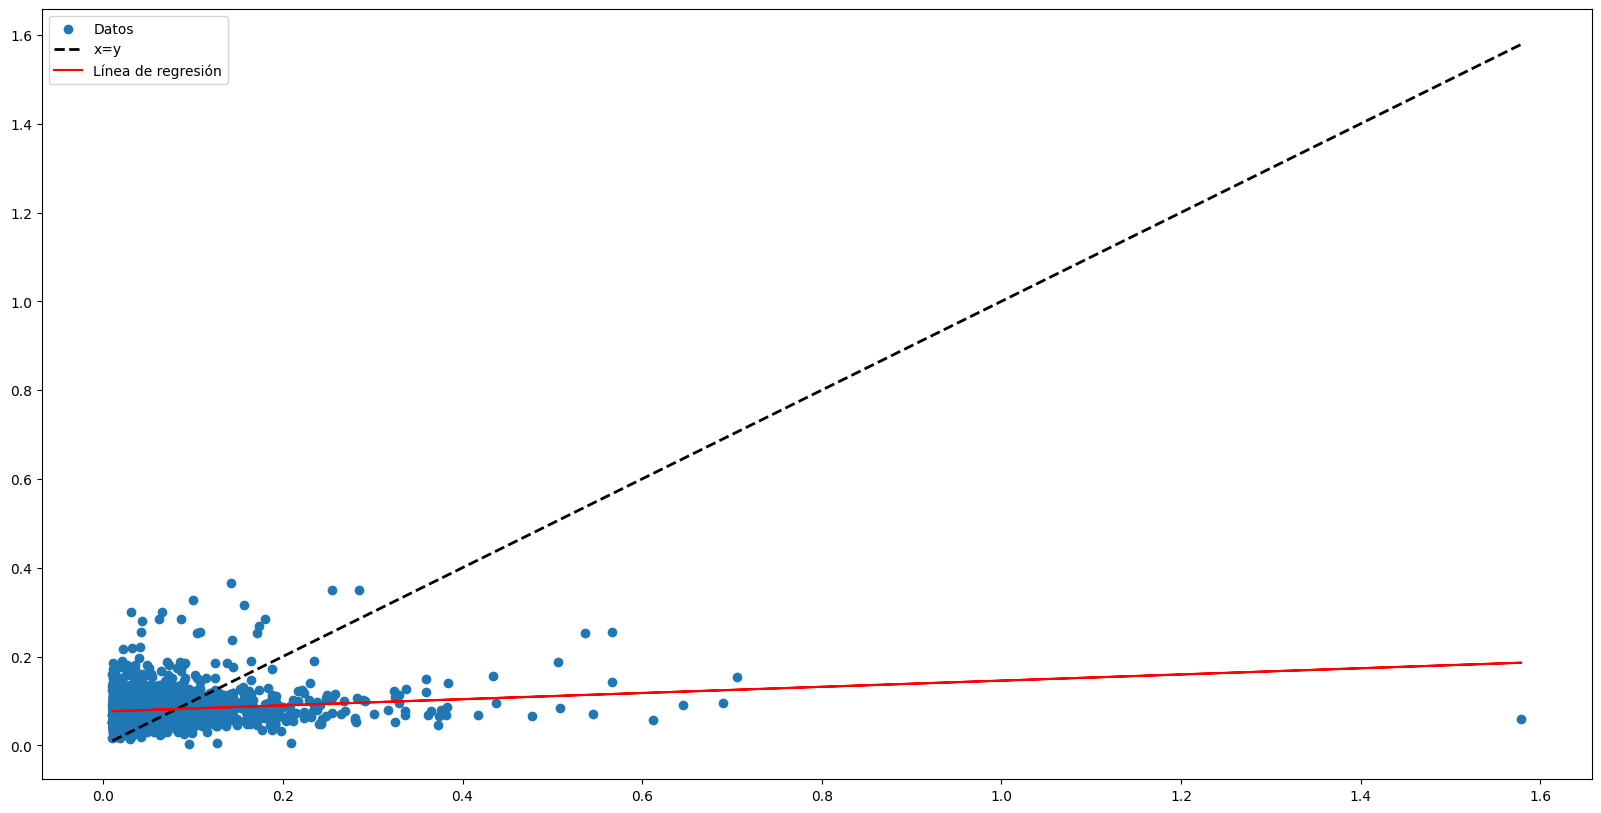

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Datos de prueba y predicciones
y_test = np.array(y_test)
y_pred = xgb_model.predict(X_test)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar el gráfico de dispersión
ax.scatter(y_test, y_pred, label="Datos")

# Dibujar la línea x=y
ax.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="x=y"
)

# Calcular la línea de regresión
reg = LinearRegression().fit(y_test.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.reshape(-1, 1))

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label="Línea de regresión")

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

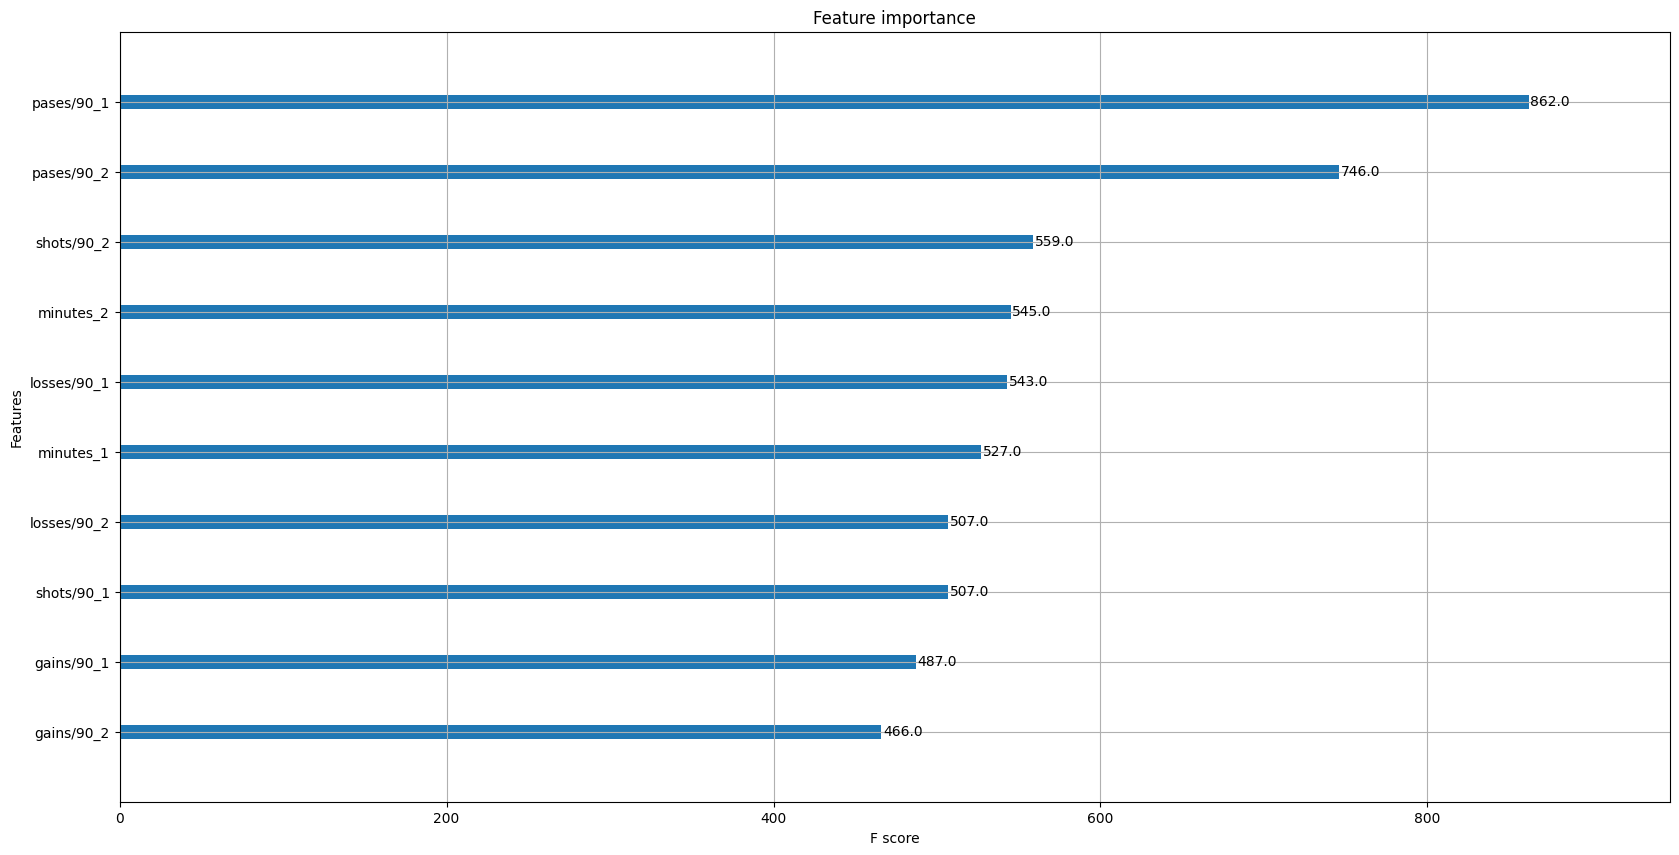

In [88]:
# Feature importance

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 10))

plot_importance(xgb_model, ax=ax)

plt.show()

<Axes: >

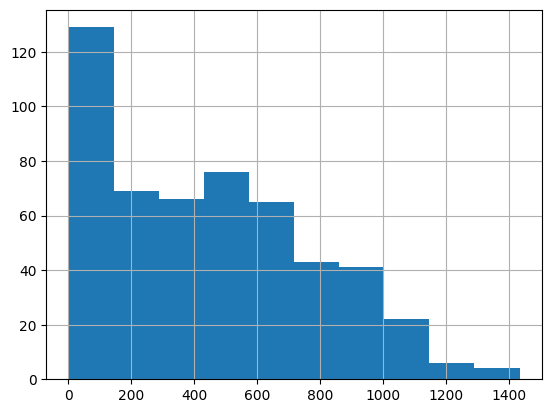

In [19]:
pd.concat([ds["player_1"], ds["player_2"]], axis=0).value_counts().hist()